In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/Github/PAC/cnn
#%cd ..

/content/drive/MyDrive/Github/PAC/cnn


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats, ndimage as nd
from skimage.transform import rotate
from src import data
from src import visualize as vs

In [3]:
jpg_files = np.array(list(data.Paths.DATA.glob('**/*.jpg')))
num_samples = len(jpg_files)
images = data.load_collection(jpg_files, grayscale=True, as_tensor=False, norm=True)
labels = data.load_collection(map(lambda file: file.with_suffix('.png'), jpg_files), grayscale=True, as_tensor=False, norm=True)
areas = np.vectorize(lambda file: float(file.stem.split('_')[0]))(jpg_files)
A_pellet = labels.sum(axis=(1, 2))
scale_true = areas/A_pellet
images.shape, labels.shape, scale_true.shape

((63, 256, 256), (63, 256, 256), (63,))

In [7]:
def FFT(x):
    return np.abs(np.fft.fft(x))

def FFT2(x):
    return np.abs(np.fft.fftshift(np.fft.fft2(x)))

def Cxx(x, mode='same'):
    return np.correlate(x, x, mode=mode)

def PSD(x):
    return FFT(Cxx(x))

def mape(y_true, y_pred):
    return np.abs(y_true-y_pred)/y_true * 100

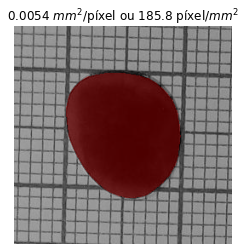

In [10]:
i = np.random.randint(num_samples)
img = images[i]
I, G, St = images[i], labels[i], scale_true[i]

vs.plot_label(I, G)
plt.title(r'{:.4f} $mm^2$/píxel ou {:.1f} píxel/$mm^2$'.format(St, 1/St))
plt.show()

# Detecção da escala

## Metodologia

In [9]:
freqs = np.fft.fftfreq(I.shape[1])
pos = freqs > 0
freqs.shape

(256,)

In [10]:
def plot_on(axs, xy, *args, **kwargs):
    for ax, (x, y) in zip(axs, xy):
        ax.plot(x, y, *args, **kwargs)

def plot_step(inpt, func, titles=None):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))

    pattern = np.random.randint(0, inpt.shape[0], 20)
    plot_on(axs.flat, [
        [range(inpt.shape[1]), inpt[pattern].T],
        [freqs[pos], np.apply_along_axis(lambda x: func(x)[pos], 1, inpt[pattern]).T]
    ], 'C0-', alpha=0.2)

    axs[1].vlines(np.sqrt(St), *axs[1].get_ylim(), color='r', lw=3, ls='dashed', label=r'$\xi_{true}$')
    axs[1].legend(fontsize=14)

    axs[1].set_xlabel(r'$\xi$ [p$^{-1}$]')
    if titles is not None: 
        for title, ax in zip(titles, axs):
            ax.set_title(title, fontsize=14)
    fig.tight_layout()
    plt.show()

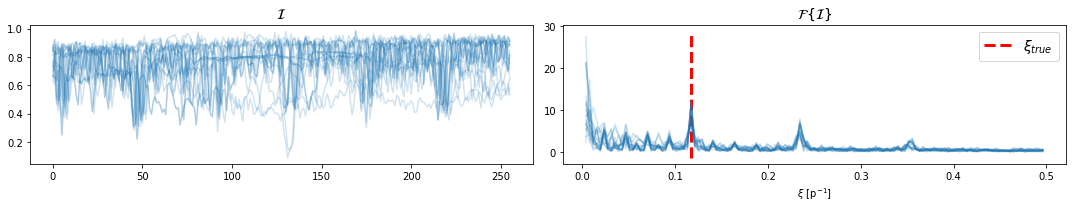

In [11]:
plot_step(I, FFT, titles=(r'$\mathcal{I}$', r'$\mathcal{F}\{\mathcal{I}\}$'))

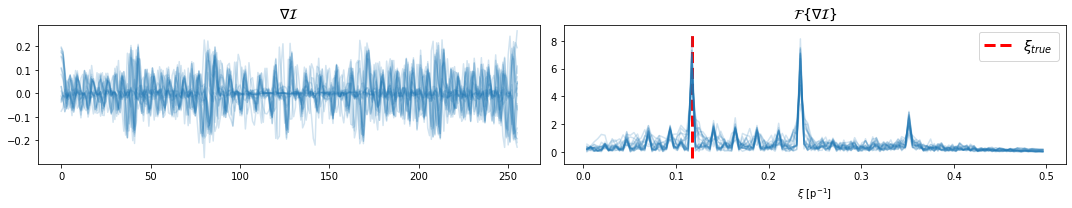

In [13]:
Ix = np.gradient(I)[0].T
plot_step(Ix, FFT, titles=(r'$\nabla\mathcal{I}$', r'$\mathcal{F}\{\nabla\mathcal{I}\}$'))

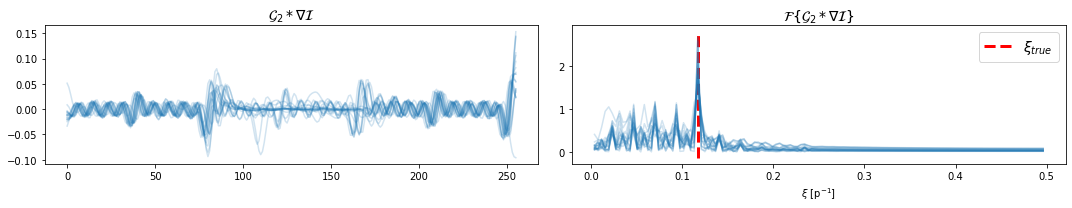

In [14]:
Ix_gauss = nd.gaussian_filter(Ix, 2)
plot_step(Ix_gauss, FFT, titles=(r'$\mathcal{G}_2*\nabla\mathcal{I}$', r'$\mathcal{F}\{\mathcal{G}_2*\nabla\mathcal{I}\}$'))

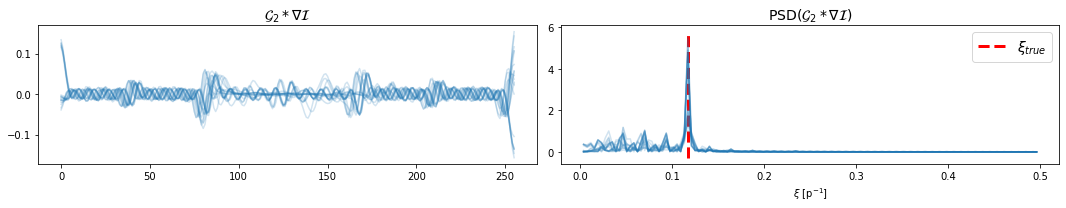

In [15]:
plot_step(Ix_gauss, PSD, titles=(r'$\mathcal{G}_2*\nabla\mathcal{I}$', r'PSD$(\mathcal{G}_2*\nabla\mathcal{I})$'))

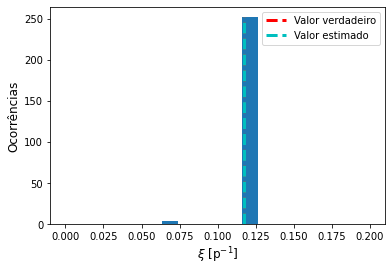

In [16]:
D = np.apply_along_axis(lambda y: np.abs(freqs[np.argmax(FFT(y))]), 1, Ix_gauss)
h, _, _ = plt.hist(D, bins=np.linspace(0, 0.2, 20))
plt.vlines(np.sqrt(St), 0, h.max(), color='r', lw=3, ls='dashed', label=r'Valor verdadeiro')
plt.vlines(stats.mode(D).mode[0], 0, h.max(), color='c', lw=3, ls='dashed', label=r'Valor estimado')
plt.legend()
plt.xlabel(r'$\xi$ [p$^{-1}$]', fontsize=12)
plt.ylabel('Ocorrências', fontsize=12)
plt.show()

## Implementação e testes

In [17]:
def find_scale(img, sigma=2, method='mean'):
    Iy, Ix = np.gradient(img)
    fs, stds = [], []
    for dI in (Ix, Iy.T):
        freqs = np.fft.fftfreq(dI.shape[1], 1)
        pos = freqs > 0
        dI_gauss = nd.gaussian_filter(dI, sigma)
        D = np.apply_along_axis(lambda y: freqs[pos][np.argmax(PSD(y)[pos])], 1, dI_gauss)

        if method == 'mean':
            fs.append(D.mean())
            stds.append(D.std())
        elif method == 'mode':
            fs.append(stats.mode(D).mode[0])
            stds.append(0.5/dI.shape[1])

    (fx, fy), (dx, dy) = fs, stds
    return fx*fy, np.sqrt((dx*fy)**2 + (dy*fx)**2)

In [18]:
gaussian_scale = np.arange(0, 10, 0.25)
out = {}
for method in ('mean', 'mode'):
    try: 
        %time out[method] = np.stack([[find_scale(image, sigma=sigma, method=method) for image in images] for sigma in gaussian_scale])
    except Exception as error: print(error)

CPU times: user 1min 18s, sys: 175 ms, total: 1min 18s
Wall time: 1min 27s
CPU times: user 1min 14s, sys: 175 ms, total: 1min 14s
Wall time: 1min 17s


1.75 4.949629986761819
2.0 2.2185189774468745


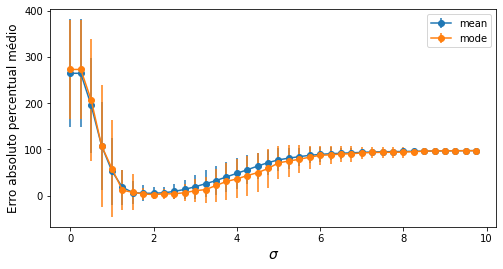

In [ ]:
plt.figure(figsize=(8, 4))

best_config = None
min_error_global = np.inf
for method, pred in out.items():
    error = mape(scale_true, pred[:, :, 0])
    plt.errorbar(gaussian_scale, error.mean(axis=1), error.std(axis=1), fmt='-o', label=method)

    min_error_loc = np.argmin(error.mean(axis=1))
    min_error = error[min_error_loc].mean()
    if min_error < min_error_global:
        min_error_global = min_error
        best_config = {'sigma':gaussian_scale[min_error_loc], 'method':method}
    print(gaussian_scale[min_error_loc], min_error)

plt.legend()
plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel('Erro absoluto percentual médio', fontsize=12)
plt.show()

CPU times: user 1.57 s, sys: 6.98 ms, total: 1.58 s
Wall time: 1.58 s


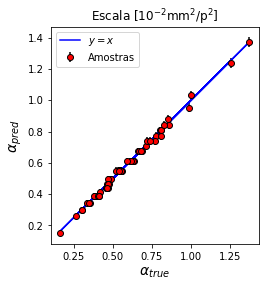

In [ ]:
%time scale_pred = np.stack([find_scale(image, **best_config) for image in images])
fig, ax = plt.subplots()
plt.errorbar(scale_true*1e2, scale_pred[:, 0]*1e2, scale_pred[:, 1]*1e2, fmt='o', markeredgecolor='k', markerfacecolor='r', color='k', label='Amostras')
plt.plot(scale_true*1e2, scale_true*1e2, 'b-', label='$y=x$')
plt.legend()
plt.title(r'Escala [10$^{-2}$mm$^2$/p$^2$]')
plt.xlabel(r'$\alpha_{true}$', fontsize=14)
plt.ylabel(r'$\alpha_{pred}$', fontsize=14)
ax.set_aspect('equal')
plt.show()

In [ ]:
rel_error = np.abs(scale_true - scale_pred[:, 0])/scale_true*100
stats.describe(rel_error)

DescribeResult(nobs=63, minmax=(0.08075609679066423, 5.804372033803283), mean=2.2185189774468745, variance=2.641252966044786, skewness=0.6594472793187326, kurtosis=-0.5979779431517991)

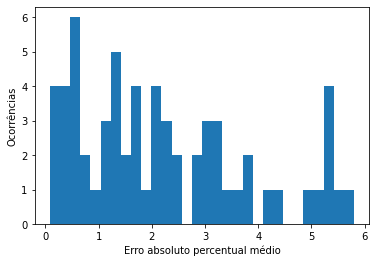

In [ ]:
plt.hist(rel_error, bins=30)
plt.ylabel('Ocorrências')
plt.xlabel('Erro absoluto percentual médio')
plt.show()

In [ ]:
i = np.random.randint(num_samples)
alpha, d_alpha = scale_pred[i]
parea = labels[i].sum()

print('Escala detectada:', '(%s +- %s) píxels/mm^2'%(1/alpha, d_alpha/alpha**2))
print('Area verdadeira:', areas[i])
print('Area estimada:', '(%s +- %s) mm^2'%(parea*alpha, parea*d_alpha))

Escala detectada: (334.3673469387755 +- 16.8881013162688) píxels/mm^2
Area verdadeira: 49.17
Area estimada: (48.12371826171875 +- 2.4306148227694444) mm^2


## Modelo tensorflow

In [ ]:
class ScaleDetector(tf.keras.Model):
    def __init__(self, sigma):
        super().__init__(trainable=False)
        self.sigma = sigma

    def build(self, input_shape): pass
    
    def call(self): pass

# Detecção da inclinação

## Metodologia

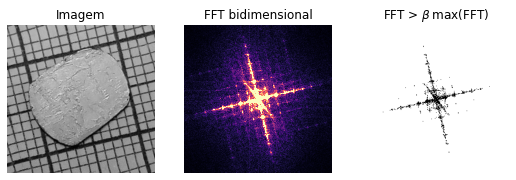

In [ ]:
angle = 15
beta = 3e-3

fig = plt.figure(figsize=(9, 3))

I = rotate(img, angle, mode='reflect')
fft2d = FFT2(I)
L = fft2d > fft2d.max()*beta

fig.add_subplot(131)
vs.plot_image(I, cmap='gray')
plt.title('Imagem')

fig.add_subplot(132)
vs.plot_image(fft2d, cmap='magma', vmax=fft2d.max()*beta)
plt.title('FFT bidimensional')

fig.add_subplot(133)
vs.plot_image(L, cmap='binary')
plt.title(r'FFT > $\beta\,\max$(FFT)')

plt.show()

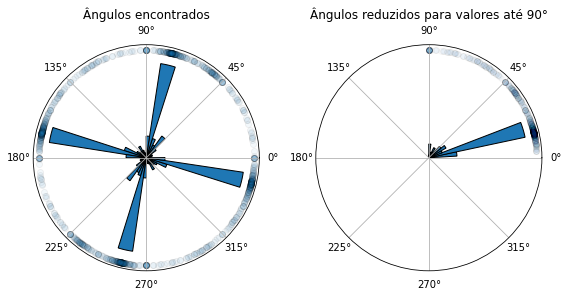

In [ ]:
X = np.arange(-I.shape[1]//2, I.shape[1]//2)
Y = np.arange(-I.shape[0]//2, I.shape[0]//2)
X, Y = np.meshgrid(X, Y)
H = np.arctan2(Y[L], X[L])
H_90 = np.pi/2 - H%(np.pi/2)

angle_pred = stats.circmean(H_90, high=np.pi/2)

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122, projection='polar')

N = 40
h, _, _ = ax1.hist(H, bins=N, width=2*np.pi/N, edgecolor='k', density=True)
ax1.scatter(H, np.full(H.shape, h.max() + h.ptp()*0.1), alpha=0.05, edgecolor='k')

N = 10
bins = np.linspace(0, np.pi/2, N+1)
h, _, _ = ax2.hist(H_90, bins=N, width=np.pi/2 * 1/N, edgecolor='k', density=True)
h_max = h.max() + h.ptp()*0.1
ax2.scatter(H_90, np.full(H.shape, h_max), alpha=0.01, edgecolor='k')

ax1.set_yticks([])
ax1.set_title('Ângulos encontrados', pad=15)
ax2.set_yticks([])
ax2.set_title('Ângulos reduzidos para valores até 90°', pad=15)
fig.tight_layout()
plt.show()

## Implementação e testes

In [ ]:
def find_slope(img, beta=2.5e-3):
    fft2d = FFT2(img)
    loc = fft2d > fft2d.max()*beta
    X = np.arange(-img.shape[1]//2, img.shape[1]//2)
    Y = np.arange(-img.shape[0]//2, img.shape[0]//2)
    X, Y = np.meshgrid(X, Y)
    H = 90 - np.degrees(np.arctan2(Y[loc], X[loc]))%90
    return stats.circmean(H, low=0, high=90), stats.circstd(H, low=0, high=90) #stats.laplace_asymmetric.fit(H)[-2:]

In [ ]:
angle_true = np.arange(1, 91)
%time angle_pred = np.stack([[find_slope(rotate(img, angle, mode='reflect'), 3e-3) for angle in angle_true] for img in images])
angle_pred.shape

CPU times: user 46.5 s, sys: 97.6 ms, total: 46.6 s
Wall time: 52.1 s


(63, 90, 2)

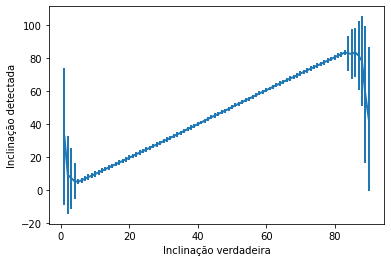

In [ ]:
plt.errorbar(angle_true, angle_pred[..., 0].mean(axis=0), angle_pred[..., 0].std(axis=0), lw=2)
plt.xlabel('Inclinação verdadeira')
plt.ylabel('Inclinação detectada')
plt.show()

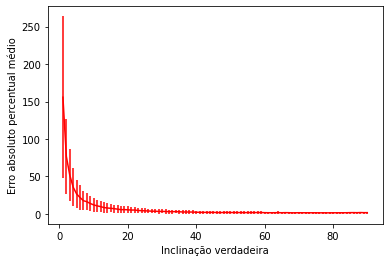

(63, 90)

In [ ]:
error_abs = np.abs(angle_true[np.newaxis] - angle_pred[..., 0])
error = np.where(error_abs > 45, np.abs(90 - error_abs), error_abs)/angle_true[np.newaxis] * 100

plt.errorbar(angle_true, error.mean(axis=0), error.std(axis=0), color='r')
plt.xlabel('Inclinação verdadeira')
plt.ylabel('Erro absoluto percentual médio')
plt.show()
error.shape

7.318171077213156

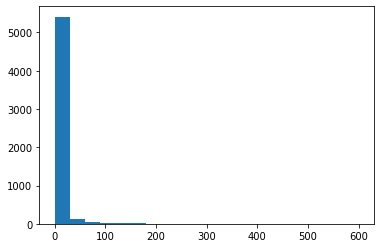

In [ ]:
plt.hist(error.flat, bins=20)
error.mean()

In [ ]:
!pip install celluloid

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.animation import PillowWriter
from celluloid import Camera

In [ ]:
fig = plt.figure(figsize=(16, 4))
#gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143, projection='polar')
ax4 = fig.add_subplot(144, projection='polar')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

def update(angle):
    I = rotate(img, angle, mode='reflect')
    fft2d = FFT2(I)
    L = fft2d > fft2d.max()*2.5e-3
    X = np.arange(-img.shape[1]//2, img.shape[1]//2)
    Y = np.arange(-img.shape[0]//2, img.shape[0]//2)
    X, Y = np.meshgrid(X, Y)
    H = np.arctan2(Y[L], X[L])
    H_90 = (np.pi/2) - H%(np.pi/2)

    ax1.imshow(I, cmap='gray')
    ax2.imshow(fft2d, cmap='magma', vmax=fft2d.max()*2.5e-3)
    ax3.hist(H, bins=40, edgecolor='k', density=True, color='C0')
    ax4.hist(H_90, bins=10, edgecolor='k', density=True, color='C0')

update(0)
fig.tight_layout()

camera = Camera(fig)
for angle in range(1, 91):
    update(angle)
    camera.snap()

animation = camera.animate()
animation.save('reports/figures/slope_detection.gif', writer=PillowWriter(fps=10))
plt.close()

![](../reports/figures/slope_detection.gif)

# Limitações

## Rotação

In [ ]:
%%time
quad = np.arange(1, 91)
out = np.stack([[find_scale(rotate(image, angle, mode='reflect'), sigma=2, method='mode') for angle in quad] for image in images])
out.shape

CPU times: user 2min 41s, sys: 256 ms, total: 2min 41s
Wall time: 2min 44s


(63, 90, 2)

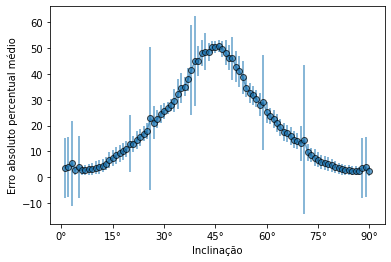

In [ ]:
abs_error = np.abs(scale_true[:, np.newaxis] - out[..., 0])
rel_error = abs_error/scale_true[:, np.newaxis] * 100
plt.errorbar(quad, rel_error.mean(axis=0), rel_error.std(axis=0), fmt='-o', alpha=0.7, markeredgecolor='k')
plt.xlabel('Inclinação')
plt.ylabel('Erro absoluto percentual médio')

loc = np.arange(0, 91, 15)
plt.xticks(loc, [f'{int(value)}°' for value in loc])

plt.show()

## Quantidade de papel milimetrado

É de se esperar que a quantidade de papel milimetrado na imagem altere a precisão do algoritmo de detecção da escala. Considere $A_{total}$ a área (em píxels) total da imagem e $A_k$ uma quantidade de área que será recortada das laterais da imagem.

Definindo 
$$
A_k = 2k(h + w) - 4k^2,
$$ 
sendo $h$ e $w$ as dimensões da imagem, temos que $k \in \left\{\mathbb{Z}|1 \le k < \frac{1}{2} \min(h, w)\right\}$, ou em outras palavras, $k$ consiste na largura que será recortada das laterais da imagem.

Seja $a_{papel}$ a quantidade relativa de papel milimetrado na imagem:
$$
a_{papel} = 1 - \frac{A_{pellet}}{A_{total} - A_k},
$$
onde $A_{pellet}$ consiste na área da região que pertence à pastílha, com a imagem já recortada.

In [5]:
h, w = images.shape[1:]
k = np.arange(1, int(min(h, w)/2) - 1)
A_total = h*w
A_k = 2*k*(h + w) - 4*k**2
a_papel = 1 - np.stack([labels[:, k_i:-k_i, k_i:-k_i].sum(axis=(1, 2)) for k_i in k])/(A_total - A_k[:, np.newaxis])
a_papel.shape

(126, 63)

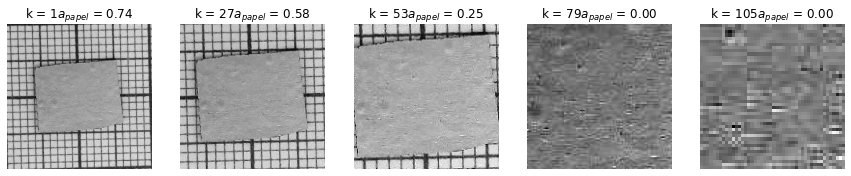

In [20]:
N = 5
fig = plt.figure(figsize=(15, 3))
for i, k_i in enumerate(k[::len(k)//N+1]):
    fig.add_subplot(1, 5, i+1)
    vs.plot_image(images[0, k_i:-k_i, k_i:-k_i], cmap='gray')
    plt.title(f'k = {k_i}'+ r'$a_{papel}$'+ f' = {a_papel[k_i == k, 0][0]:.2f}')

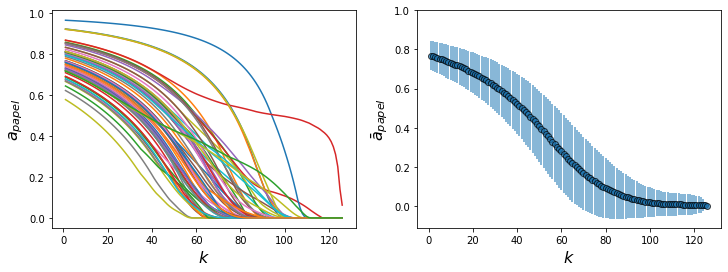

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k, a_papel)
ax1.set_xlabel(r'$k$', fontsize=16)
ax1.set_ylabel(r'$a_{papel}$', fontsize=16)
ax1.set_yticks(ax1.get_yticks()[1:-1])

ax2.errorbar(k, a_papel.mean(axis=1), a_papel.std(axis=1), fmt='-o', markeredgecolor='k', alpha=0.7)
ax2.set_xlabel(r'$k$', fontsize=16)
ax2.set_ylabel(r'$\bar{a}_{papel}$', fontsize=16)
ax2.set_yticks(ax1.get_yticks())

plt.show()

In [ ]:
%%time
scale_k = np.stack([[find_scale(image[k_i:-k_i, k_i:-k_i], sigma=2, method='mode')[0] for image in images] for k_i in k])
scale_k.shape

CPU times: user 1min 26s, sys: 213 ms, total: 1min 26s
Wall time: 1min 27s


(126, 63)

In [ ]:
abs_error = np.abs(scale_true[np.newaxis] - scale_k)
rel_error = abs_error/scale_true[np.newaxis] * 100
rel_error.shape

(126, 63)

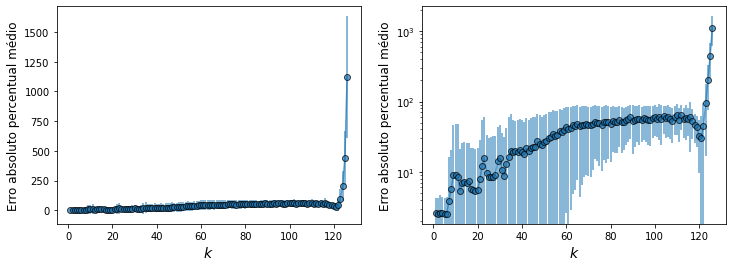

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.errorbar(k, rel_error.mean(axis=1), rel_error.std(axis=1), fmt='-o', alpha=0.7, markeredgecolor='k')
ax2.errorbar(k, rel_error.mean(axis=1), rel_error.std(axis=1), fmt='-o', alpha=0.7, markeredgecolor='k')
ax2.semilogy()

for ax in (ax1, ax2):
    ax.set_xlabel(f'$k$', fontsize=14)
    ax.set_ylabel('Erro absoluto percentual médio', fontsize=12)
plt.show()

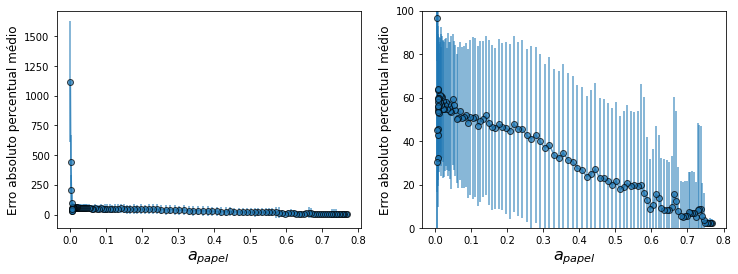

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.errorbar(a_papel.mean(axis=1), rel_error.mean(axis=1), rel_error.std(axis=1), fmt='-o', alpha=0.7, markeredgecolor='k')
ax2.errorbar(a_papel.mean(axis=1), rel_error.mean(axis=1), rel_error.std(axis=1), fmt='-o', alpha=0.7, markeredgecolor='k')
ax2.set_ylim(0, 100)

for ax in (ax1, ax2):
    ax.set_xlabel('$a_{papel}$', fontsize=16)
    ax.set_ylabel('Erro absoluto percentual médio', fontsize=12)
plt.show()